<a href="https://colab.research.google.com/github/ChuloIva/ma-staff/blob/main/Predict_Clean01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import re
from datetime import datetime
import plotly.express as px
from scipy.stats import chi2_contingency
import numpy as np
import plotly.graph_objects as go

In [2]:

import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
from tensorflow.keras import models, layers, preprocessing as kprocessing
from prophet import Prophet



In [3]:
def merge_product_groups(dataset):
    # Create a copy of the dataset to avoid modifying the original
    merged_dataset = dataset.copy()

    # Define the merging and renaming rules
    merge_rules = {
        'KOMPJUTERI': 'PC',
        'RAČUNALA-NOTEBOOKS': 'PC',
        'HLADNJAK': 'HLADNJACI',
        'AP.': 'APARATI',
        'APARAT': 'APARATI',
        'CRO/REMINGTON': 'APARATI',
        'GSM': 'TELEFONI',
        'KORKMAZ': 'POSUĐE',
        'ZAMRZIVAČ': 'ZAMRZIVAČI',
        'NAPA': 'NAPE'
    }

    # Merge and rename product groups
    merged_dataset['Naziv'] = merged_dataset['Naziv'].replace(merge_rules)

    # Group by the merged product groups and sum the revenue
    merged_dataset = merged_dataset.groupby(['Date', 'Naziv'], as_index=False)['Bruto'].sum()

    return merged_dataset


def merge_rows_by_product_name(df):
    # Define a function to extract the second word from a given string
    def get_second_word(string):
        words = re.findall(r'\w+', string)
        if len(words) >= 2:
            return words[1]
        else:
            return ''

    # Apply the function to create a new column with the second word
    df['Second_Word'] = df['Naziv'].apply(get_second_word)

    # Group the dataframe by the first word of the product name and sum the revenue
    grouped_df = df.groupby(['Date', df['Naziv'].str.split().str[1]])['Bruto'].sum().reset_index()

    # Rename the columns for clarity
    grouped_df.columns = ['Date', 'Naziv', 'Bruto']

    return grouped_df


def extract_month_year(file_name):
    # Assuming the file name follows the format: "Grupe - month year.xlsx"
    name_parts = file_name.split(" - ")[1].split(".")[0].split(" ")
    month_name = name_parts[0]
    year = int(name_parts[1])

    # Convert month name to its corresponding numeric representation
    month = datetime.strptime(month_name, '%B').month

    return month, year

In [4]:
def import_excel_files3(folder_path):
    combined_data = pd.DataFrame()  # Initialize an empty DataFrame for combined data

    # Iterate through each file in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".xlsx"):
            # Construct the file path
            file_path = os.path.join(folder_path, file_name)

            # Read the XLSX file into a DataFrame
            df = pd.read_excel(file_path)

            # Extract the fourth row as column names
            new_header = df.iloc[3]

            # Set the column names
            df.columns = new_header

            # Remove preceding rows and reset the index
            df = df[4:].reset_index(drop=True)

            # Remove the last three rows
            df = df.iloc[:-3]

            # Extract month and year from file name
            month, year = extract_month_year(file_name)

            # Add a datetime column with the name of the file
            df['Date'] = datetime(year=year, month=month, day=1)


            df = merge_rows_by_product_name(df)

            df = merge_product_groups(df)

            combined_data = combined_data.append(df, ignore_index=True)

    return combined_data

In [5]:

# Folder path containing XLSX files
folder_path = "/content/drive/MyDrive/ML predict data/XLSX"

Final = import_excel_files3(folder_path)

<ipython-input-4-2eee51ce9b3c>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = combined_data.append(df, ignore_index=True)
<ipython-input-4-2eee51ce9b3c>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = combined_data.append(df, ignore_index=True)
<ipython-input-4-2eee51ce9b3c>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = combined_data.append(df, ignore_index=True)
<ipython-input-4-2eee51ce9b3c>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_data = combined_data.append(df, ignore_index=True)
<ipython-input-4-2eee51ce9b3c>:36: FutureWarning: The frame.append method is dep

In [6]:
Final

,Date,Naziv,Bruto
0,2020-08-01,ANT.OPREMA,1563.68
1,2020-08-01,APARATI,12256.32
2,2020-08-01,AUTO,822.14
3,2020-08-01,BATERIJE,340.48
4,2020-08-01,BEŠTECI,552.32
...,...,...,...
2152,2023-02-01,ČAŠE,579.70
2153,2023-02-01,ĐEZVE/ČAJNICI,9.72
2154,2023-02-01,ŠALICE/KIDS-HELLO,324.24
2155,2023-02-01,ŠK.OPREMA,79.20


In [7]:
pivot_table3 = pd.pivot_table(Final, values='Bruto', index='Date', columns='Naziv', aggfunc='sum', fill_value=0)

pivot_table3

Naziv,ALAT,ANT.OPREMA,APARATI,ASORTIMAN,AUTO,BATERIJE,BEŠTECI,BICIKLI,BOJLER,BOJLERI,...,WALKMANI,YAMAHA,ZAMRZIVAČI,ZVUČNICI,ČAŠE,ĐEZVE/ČAJNICI,ŠALICE/KIDS-HELLO,ŠK.OPREMA,ŠTEDNJACI,ŽARULJE
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,0.00,875.12,11247.25,0.00,507.82,437.35,410.68,1794.28,0.00,520.39,...,0,3623.97,9012.05,0.00,174.38,30.49,0.00,12.21,15597.44,0.00
2020-06-01,499.03,1127.14,12133.61,0.00,819.52,350.82,846.23,2841.17,0.00,1037.84,...,0,4253.87,11026.77,191.01,264.04,43.10,0.00,0.00,16334.72,0.00
2020-07-01,0.00,1214.06,14052.77,0.00,585.62,278.63,230.45,1040.48,0.00,1139.51,...,0,2678.29,12641.69,0.00,388.47,27.61,0.00,0.00,15034.45,3.16
2020-08-01,0.00,1563.68,12256.32,0.00,822.14,340.48,552.32,3025.87,0.00,871.04,...,0,1930.07,8361.97,1446.14,355.92,33.02,0.00,0.00,17468.09,0.00
2020-09-01,0.00,2596.55,9523.81,0.00,1039.44,240.41,328.15,1677.54,0.00,202.87,...,0,1608.57,7359.36,31.84,341.59,20.27,0.00,0.00,10547.52,0.00
2020-10-01,-79.67,22554.76,9255.82,0.00,1079.63,419.62,155.22,286.66,0.00,991.69,...,0,1759.55,10695.84,153.42,435.84,31.95,0.00,12.21,12510.98,0.00
2020-11-01,0.00,8815.67,10890.18,0.00,188.41,337.32,89.74,106.18,0.00,424.45,...,0,1695.47,12793.95,0.00,303.22,27.61,0.00,0.00,8885.99,0.00
2020-12-01,0.00,5285.29,24063.28,0.00,744.73,416.08,481.53,1008.62,0.00,1419.54,...,0,3066.03,7851.92,31.84,737.98,11.15,0.00,0.00,12901.67,0.00
2021-01-01,0.00,3719.96,27200.91,0.00,375.24,360.73,141.95,260.12,0.00,560.51,...,0,2216.58,8232.51,31.84,464.56,67.08,0.00,0.00,12963.54,3.76


In [8]:
print(pivot_table3.columns)

Index(['ALAT', 'ANT.OPREMA', 'APARATI', 'ASORTIMAN', 'AUTO', 'BATERIJE',
       'BEŠTECI', 'BICIKLI', 'BOJLER', 'BOJLERI', 'BONOVI', 'CD', 'CIGARETE',
       'CONRAD', 'DEKORACIJA', 'DVD', 'ELEKTRO', 'EMO', 'FOTO', 'GARAŽNA',
       'GRIJALICE', 'GSO', 'HISENSE', 'HLADNJACI', 'I', 'IGRICE', 'KAMERE',
       'KARTELA', 'KIDS-HELLO', 'KLIMA', 'KOFERI', 'KOMPONENTE', 'KOSILICE',
       'KRISTAL', 'KUHALA', 'KUHINJE', 'KUĆNA', 'LINIJE', 'LJESTVE', 'LONCI',
       'METALAC', 'MIKROVALNE', 'MOBIDOM', 'MP3', 'NADZORNA', 'NAPE', 'NITOR',
       'NOVOGODIŠNJI', 'OKVIR', 'OŠT.AMBALAŽA', 'OŠT.APARATI', 'P.POSUĐA',
       'PC', 'PERILICE', 'PEĆI', 'PLINSKE', 'POSUĐE', 'PROČIŠ./ODVL./OVL.',
       'RADIO', 'RAZNA', 'ROBA-SUBOTA', 'ROŠTILJI', 'SALVETE/SVIJEĆE',
       'SLUŠALICE', 'SOLAR', 'SPORTSKA', 'STALCI', 'SUŠILICE', 'SVAŠTARA',
       'TABLETI', 'TACNE', 'TANJURI/SERVISI', 'TAVE', 'TELEFONI', 'TELEVIZORI',
       'TINTE', 'TORBICE', 'TV', 'USISAVAČI', 'VAGE', 'VAZA/PEP/SVIJEĆE',
       'VENTI

In [9]:
# Reset the index
pivot_table3 = pivot_table3.reset_index()

In [10]:
# Melt the pivot table to reshape it for plotting
melted_table = pd.melt(pivot_table3, id_vars='Date', var_name='Proizvod', value_name='Revenue')

# Set the dark color scheme
px.defaults.template = "plotly_dark"

# Rename the columns
melted_table = melted_table.rename(columns={'index': 'Date'})

# Create a line chart
fig = px.line(melted_table, x='Date', y='Revenue', color='Proizvod')

# Display the chart
fig.show()

In [11]:
melted_table

,Date,Proizvod,Revenue
0,2020-05-01,ALAT,0.00
1,2020-06-01,ALAT,499.03
2,2020-07-01,ALAT,0.00
3,2020-08-01,ALAT,0.00
4,2020-09-01,ALAT,0.00
...,...,...,...
3436,2023-01-01,ŽARULJE,0.00
3437,2023-02-01,ŽARULJE,0.00
3438,2023-03-01,ŽARULJE,0.00
3439,2023-04-01,ŽARULJE,16.72


In [12]:
pivot_table4 = pd.pivot_table(Final, values='Bruto', index='Date', columns='Naziv', aggfunc='sum', fill_value=0)

pivot_table4

Naziv,ALAT,ANT.OPREMA,APARATI,ASORTIMAN,AUTO,BATERIJE,BEŠTECI,BICIKLI,BOJLER,BOJLERI,...,WALKMANI,YAMAHA,ZAMRZIVAČI,ZVUČNICI,ČAŠE,ĐEZVE/ČAJNICI,ŠALICE/KIDS-HELLO,ŠK.OPREMA,ŠTEDNJACI,ŽARULJE
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01,0.00,875.12,11247.25,0.00,507.82,437.35,410.68,1794.28,0.00,520.39,...,0,3623.97,9012.05,0.00,174.38,30.49,0.00,12.21,15597.44,0.00
2020-06-01,499.03,1127.14,12133.61,0.00,819.52,350.82,846.23,2841.17,0.00,1037.84,...,0,4253.87,11026.77,191.01,264.04,43.10,0.00,0.00,16334.72,0.00
2020-07-01,0.00,1214.06,14052.77,0.00,585.62,278.63,230.45,1040.48,0.00,1139.51,...,0,2678.29,12641.69,0.00,388.47,27.61,0.00,0.00,15034.45,3.16
2020-08-01,0.00,1563.68,12256.32,0.00,822.14,340.48,552.32,3025.87,0.00,871.04,...,0,1930.07,8361.97,1446.14,355.92,33.02,0.00,0.00,17468.09,0.00
2020-09-01,0.00,2596.55,9523.81,0.00,1039.44,240.41,328.15,1677.54,0.00,202.87,...,0,1608.57,7359.36,31.84,341.59,20.27,0.00,0.00,10547.52,0.00
2020-10-01,-79.67,22554.76,9255.82,0.00,1079.63,419.62,155.22,286.66,0.00,991.69,...,0,1759.55,10695.84,153.42,435.84,31.95,0.00,12.21,12510.98,0.00
2020-11-01,0.00,8815.67,10890.18,0.00,188.41,337.32,89.74,106.18,0.00,424.45,...,0,1695.47,12793.95,0.00,303.22,27.61,0.00,0.00,8885.99,0.00
2020-12-01,0.00,5285.29,24063.28,0.00,744.73,416.08,481.53,1008.62,0.00,1419.54,...,0,3066.03,7851.92,31.84,737.98,11.15,0.00,0.00,12901.67,0.00
2021-01-01,0.00,3719.96,27200.91,0.00,375.24,360.73,141.95,260.12,0.00,560.51,...,0,2216.58,8232.51,31.84,464.56,67.08,0.00,0.00,12963.54,3.76


Point Biserial Correlation:
The point biserial correlation is used to measure the relationship between a binary variable and a continuous variable. In your case, you can treat one of the product groups as a binary variable (e.g., comparing sales trends between one specific product group and others).

In [13]:
from scipy.stats import pointbiserialr

# Choose a specific product group to compare with others
product_group = 'HLADNJACI'

# Create a binary variable indicating whether the chosen product group or not
melted_table['Is_Selected'] = melted_table['Proizvod'].apply(
    lambda x: 1 if x == product_group else 0
)

# Calculate point biserial correlationlll
r, p_value = pointbiserialr(melted_table['Is_Selected'], melted_table['Revenue'])

# Print the results
print("Point Biserial Correlation:", r)
print("p-value:", p_value)

Point Biserial Correlation: 0.3466474427620856
p-value: 9.801097486036145e-98


In [14]:
def visualize_point_biserial_correlation(melted_table):
    correlations = []

    # Iterate over each unique product category
    for product_category in melted_table['Proizvod'].unique():
        # Create a binary variable indicating whether the product category matches or not
        melted_table['Is_Selected'] = melted_table['Proizvod'].apply(
            lambda x: 1 if x == product_category else 0
        )

        # Calculate point biserial correlation
        r, _ = pointbiserialr(melted_table['Is_Selected'], melted_table['Revenue'])

        # Append the correlation and category to the list
        correlations.append((product_category, r))

    # Sort the correlations in descending order
    correlations = sorted(correlations, key=lambda x: x[1], reverse=True)

    # Extract the categories and correlations for plotting
    categories = [x[0] for x in correlations]
    corr_values = [x[1] for x in correlations]

    # Create a bar plot using Plotly
    fig = go.Figure(data=go.Bar(x=categories, y=corr_values))

    fig.update_layout(
        title="Point Biserial Correlation for Product Categories",
        xaxis_title="Product Categories",
        yaxis_title="Correlation",
        width=800,
        height=600,
        plot_bgcolor='rgb(17, 17, 17)',  # Dark background color
        paper_bgcolor='rgb(17, 17, 17)',  # Dark background color
        font=dict(color='white'),  # Font color
    )

    # Display the plot
    fig.show()

In [15]:
visualize_point_biserial_correlation(melted_table)

## Interpreting the Graph:
By examining the graph, you can gain insights into the product categories that exhibit the strongest positive or negative correlations with the revenue. The product categories associated with the tallest bars on the left side of the graph have the highest positive correlations. These categories are likely to have a significant impact on revenue, and an increase in their presence may lead to higher revenue. On the other hand, the product categories associated with the tallest bars on the right side of the graph have the highest negative correlations. These categories may have a negative impact on revenue, and reducing their presence could potentially increase revenue.

Overall, the graph allows you to visually identify the product categories that show the strongest relationships with revenue, helping you prioritize and make informed decisions regarding product assortment, marketing strategies, or other relevant factors related to maximizing revenue.

Malo tako analize, Dobili smo ajmo rec top neke proizvode na kojima cemo radit seme.

PERILICE

HLADNJACI

APARATI

ŠTEDNJACI

TELEVIZORI

PC

KLIMA

TELEFONI

ZAMRZIVAČI

SUŠILICE

POSUĐE

USISAVAČI

PEĆI

YAMAHA

In [16]:
desired_values = [
    "PERILICE",
    "HLADNJACI",
    "APARATI",
    "ŠTEDNJACI",
    "TELEVIZORI",
    "PC",
    "KLIMA",
    "TELEFONI",
    "ZAMRZIVAČI",
    "SUŠILICE",
    "POSUĐE",
    "USISAVAČI",
    "PEĆI",
    "YAMAHA"
]

# Select the desired columns from the DataFrame
final_clean = Final[Final["Naziv"].isin(desired_values)]

In [17]:
pivot_table4 = pd.pivot_table(final_clean, values='Bruto', index='Date', columns='Naziv', aggfunc='sum', fill_value=0)

pivot_table4

Naziv,APARATI,HLADNJACI,KLIMA,PC,PERILICE,PEĆI,POSUĐE,SUŠILICE,TELEFONI,TELEVIZORI,USISAVAČI,YAMAHA,ZAMRZIVAČI,ŠTEDNJACI
Date,,,,,,,,,,,,,,
2020-05-01,11247.25,18867.79,4723.18,16749.99,33012.81,848.15,2801.87,4109.41,7302.74,14681.26,5234.91,3623.97,9012.05,15597.44
2020-06-01,12133.61,19752.42,21946.23,13301.54,28011.93,1267.97,2127.49,3052.51,10389.05,16001.16,3000.62,4253.87,11026.77,16334.72
2020-07-01,14052.77,29660.91,26604.45,12907.63,34425.48,1203.34,3066.14,2245.59,10117.00,14401.83,5158.42,2678.29,12641.69,15034.45
2020-08-01,12256.32,20910.99,11489.20,15069.05,32140.35,3010.45,3826.24,3402.91,8392.57,13081.77,5007.16,1930.07,8361.97,17468.09
2020-09-01,9523.81,16084.47,2256.20,19146.26,20647.68,1198.89,3812.72,2248.91,9133.62,10418.71,4395.88,1608.57,7359.36,10547.52
2020-10-01,9255.82,12380.00,2618.91,16587.92,14717.88,5666.06,2351.31,7960.89,6901.36,41586.00,4684.73,1759.55,10695.84,12510.98
2020-11-01,10890.18,8168.18,0.00,11159.42,19168.82,3951.27,2036.38,13046.87,7199.45,23180.31,4107.68,1695.47,12793.95,8885.99
2020-12-01,24063.28,8878.30,1920.48,36030.09,27759.91,3293.20,5963.43,9545.33,13278.02,27633.31,4328.35,3066.03,7851.92,12901.67
2021-01-01,27200.91,10787.27,265.43,18547.00,22096.15,1721.62,4445.82,8323.80,8870.19,22389.68,4680.30,2216.58,8232.51,12963.54


In [18]:
#Extracting one by one value for ML.


proizvod = ["KLIMA"]

columns = ['Date', 'Bruto']

ml_df2 = Final[Final["Naziv"].isin(proizvod)]


ml_df = ml_df2[columns]



# Feature engineering

In [19]:
df = ml_df

df = df.rename(columns={'Bruto': 'revenue',
                        'Date': 'date'})
df = df.sort_values('date')

In [20]:
# Assuming your data is stored in a DataFrame called 'df' with a 'date' column
df['date'] = pd.to_datetime(df['date'])

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Compute lag features for previous month(s) and the same month in the previous year
df['revenue_lag_1'] = df['revenue'].shift(1)
df['revenue_lag_2'] = df['revenue'].shift(2)

# Calculate monthly average revenue
monthly_average = df.groupby(['year', 'month'])['revenue'].mean()

# Merge the average revenue back into the main DataFrame
df = df.merge(monthly_average, on=['year', 'month'], suffixes=('', '_avg_monthly'))

# Calculate percentage change features
df['revenue_pct_change_1'] = df['revenue'].pct_change(1)
df['revenue_pct_change_12'] = df['revenue'].pct_change(12)


In [21]:
# Encode month-of-year and quarter-of-year as trigonometric features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Assuming your data is stored in a DataFrame called 'df' with a 'month' column
df['quarter'] = ((df['month'] - 1) // 3) + 1

# Encode month-of-year and quarter-of-year as trigonometric features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

# Calculate difference features
df['revenue_diff_1'] = df['revenue'].diff(1)
df['revenue_diff_2'] = df['revenue'].diff(2)

# Calculate aggregated features
df['revenue_mean_year'] = df.groupby('year')['revenue'].transform('mean')
df['revenue_max_quarter'] = df.groupby('quarter')['revenue'].transform('max')
df['rolling_mean_6'] = df['revenue'].rolling(window=6).mean()
df['rolling_std_12'] = df['revenue'].rolling(window=12).std()

# Create binary features
df['above_average'] = (df['revenue'] > df['revenue_mean_year']).astype(int)
df['positive_growth'] = (df['revenue_diff_1'] > 0).astype(int)


# Interaction features
df['revenue_ratio_lag1'] = df['revenue'] / df['revenue_lag_1']
df['revenue_diff_ratio'] = df['revenue_diff_1'] / df['revenue_diff_2']


In [22]:
print(df.columns)

Index(['date', 'revenue', 'year', 'month', 'revenue_lag_1', 'revenue_lag_2',
       'revenue_avg_monthly', 'revenue_pct_change_1', 'revenue_pct_change_12',
       'month_sin', 'month_cos', 'quarter', 'quarter_sin', 'quarter_cos',
       'revenue_diff_1', 'revenue_diff_2', 'revenue_mean_year',
       'revenue_max_quarter', 'rolling_mean_6', 'rolling_std_12',
       'above_average', 'positive_growth', 'revenue_ratio_lag1',
       'revenue_diff_ratio'],
      dtype='object')


# FACEBOOK PROPHET

In [23]:
exogenous_features_list = ['year', 'month', 'revenue_lag_1', 'revenue_lag_2',
       'revenue_avg_monthly', 'revenue_pct_change_1', 'revenue_pct_change_12',
       'month_sin', 'month_cos', 'quarter', 'quarter_sin', 'quarter_cos',
       'revenue_diff_1', 'revenue_diff_2', 'revenue_mean_year',
       'revenue_max_quarter', 'rolling_mean_6', 'rolling_std_12',
       'above_average', 'positive_growth', 'revenue_ratio_lag1',
       'revenue_diff_ratio']

exogenous_features = df[exogenous_features_list]

In [24]:
# Create a new DataFrame with the required columns for Prophet
prophet_df = df
prophet_df.rename(columns={'date': 'ds', 'revenue': 'y'}, inplace=True)

In [25]:
# # Create a new DataFrame with the required columns for Prophet
# prophet_df = df[['date', 'revenue']].copy()
# prophet_df.rename(columns={'date': 'ds', 'revenue': 'y'}, inplace=True)

In [26]:
# Define the train-test split point
split_date = pd.to_datetime('2023-01-01')

# Split the data into train and test sets
train_df = prophet_df[prophet_df['ds'] < split_date]
test_df = prophet_df[prophet_df['ds'] >= split_date]

In [27]:
from prophet import Prophet
model = Prophet()

for feature in exogenous_features:
	model.add_regressor(feature)


In [28]:
# Fit the Prophet model with the training data
model = Prophet()
model.fit(train_df)

# Make predictions on the test data
future = model.make_future_dataframe(periods=len(test_df), freq='M')
test_forecast = model.predict(future)

# Compare predicted values with actual values
test_df['y_pred'] = test_forecast['yhat'].tail(len(test_df))
test_df[['ds', 'y', 'y_pred']].head()

# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_df['y'], test_df['y_pred'])
rmse = mean_squared_error(test_df['y'], test_df['y_pred'], squared=False)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmperwafkw8/rpd6x0fw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmperwafkw8/8n_gd1oz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56366', 'data', 'file=/tmp/tmperwafkw8/rpd6x0fw.json', 'init=/tmp/tmperwafkw8/8n_gd1oz.json', 'output', 'file=/tmp/tmperwafkw8/prophet_modelbl4tsvct/prophet_model-20230626073756.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
07:37:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:

MAE: 12082.544826359826
RMSE: 16952.211182431263


In [29]:
# # Create a new DataFrame with the required columns for Prophet
# prophet_df = df[['date', 'revenue']].copy()
# prophet_df.rename(columns={'date': 'ds', 'revenue': 'y'}, inplace=True)

# # Add additional features to the Prophet DataFrame
# prophet_df['month_sin'] = df['month_sin']
# prophet_df['month_cos'] = df['month_cos']
# prophet_df['quarter_sin'] = df['quarter_sin']
# prophet_df['quarter_cos'] = df['quarter_cos']

# # Initialize and fit the Prophet model
# model = Prophet()
# model.fit(prophet_df)

# # Make predictions
# future = model.make_future_dataframe(periods=5, freq='M')  # Example: Predicting 12 months ahead
# forecast = model.predict(future)

Prophet stvari pastedump

In [30]:
# # 7. define the parameters for the forecasting model — trend and seasonality

# #define the forecasting model parameters, trend = logistic growth, yearly seasonality = multiplicative, no holiday parameter
# model_params = {"daily_seasonality": False, "weekly_seasonality": False, "yearly_seasonality": True, "seasonality_mode": "multiplicative", "growth": "logistic"}

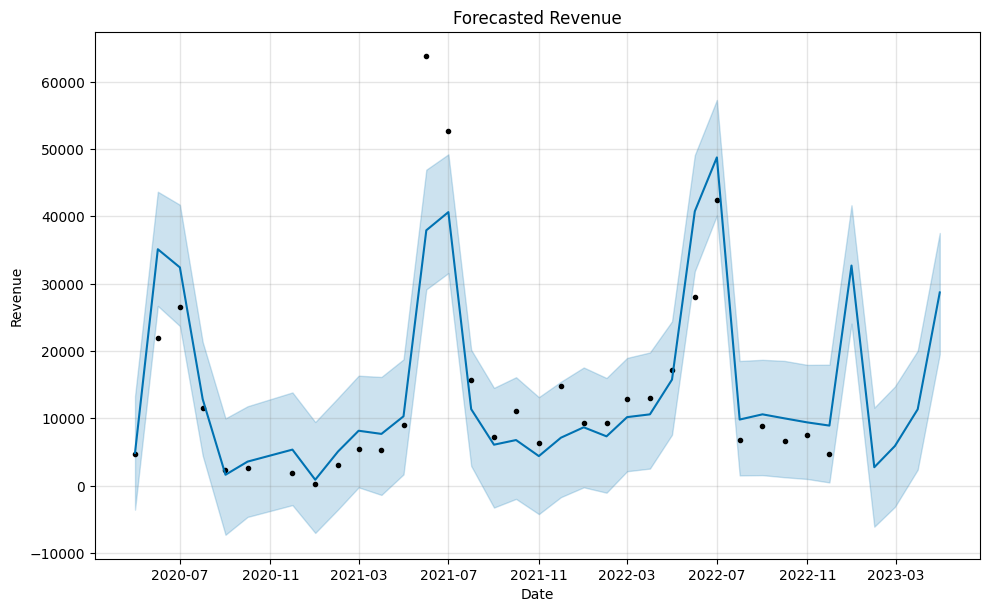

In [31]:
# Plot forecasted revenue
fig = model.plot(test_forecast)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Forecasted Revenue')
plt.show()

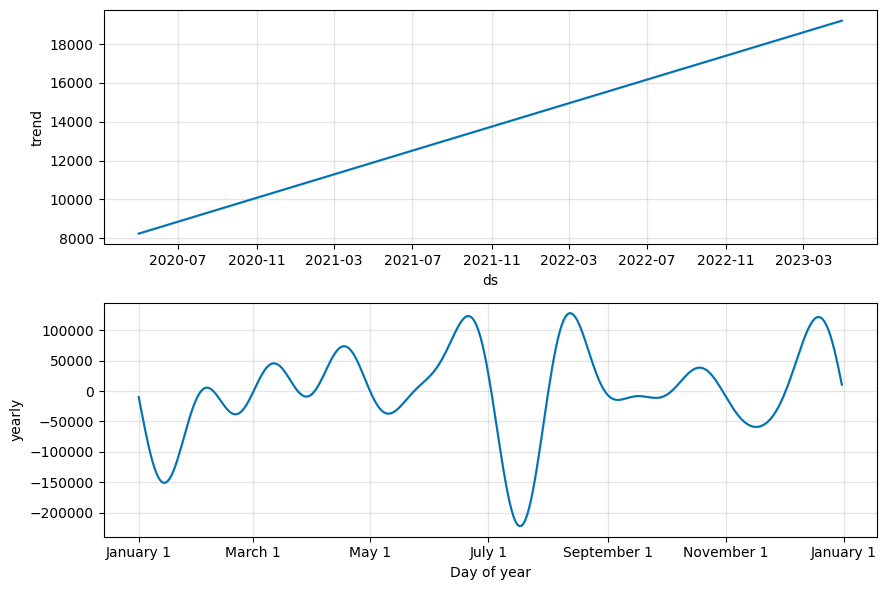

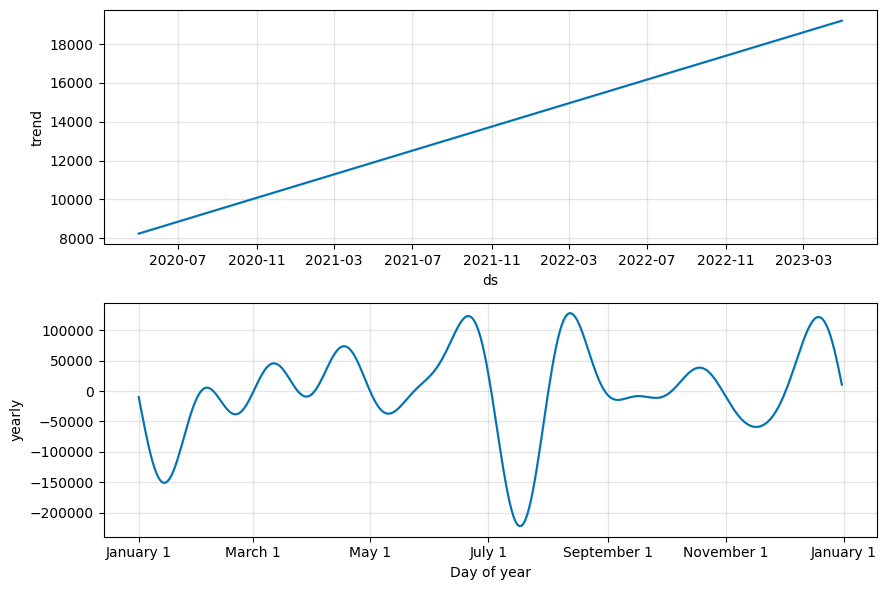

In [32]:

model.plot_components(test_forecast)

In [33]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df['ds'], y=df['y'], mode='lines', name='Historical Data'))
fig2.add_trace(go.Scatter(x=test_forecast['ds'], y=test_forecast['yhat'], mode='lines', name='Predicted Data'))
fig2.update_layout(
plot_bgcolor='rgb(17, 17, 17)',  # Dark background color
paper_bgcolor='rgb(17, 17, 17)',  # Dark background color
font=dict(color='white'),  # Font color
xaxis=dict(title='Date'),
yaxis=dict(title='Revenue'),
title='Forecasted Revenue'
)
fig2.show()